In [1]:
import torch
from torchvision import transforms, datasets, models
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import skimage.io as io
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [2]:
# class CustomNormalize(object):
#     def __call__(self, tensor):
       
#         tensor[0] = tensor[0] * 1.6  # aumenta la intensidad del canal rojo
#         tensor[1] = tensor[1] * 1.6  # aumenta la intensidad del canal verde (para resaltar el blanco)
#         tensor[2] = tensor[2] * 1.6  # aumenta la intensidad del canal azul (para resaltar el blanco)
#         return tensor
    

transform = transforms.Compose([
    transforms.Resize((200,200)),  
    transforms.ToTensor()
    #transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.9, hue=0.1),
    #transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    # CustomNormalize()
])
ruta_entrenamiento = os.path.join(os.getcwd(),'dataset','train')#"C:/Users/basti/OneDrive/Escritorio/bigdataseñaleticas/dataset/train"
ruta_validacion    = os.path.join(os.getcwd(),'dataset','val')#"C:/Users/basti/OneDrive/Escritorio/bigdataseñaleticas/dataset/val"

conjunto_entrenamiento = datasets.ImageFolder(root=ruta_entrenamiento, transform=transform)
conjunto_validacion = datasets.ImageFolder(root=ruta_validacion, transform=transform)

train_loader = torch.utils.data.DataLoader(conjunto_entrenamiento, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(conjunto_validacion, batch_size=16, shuffle=False)



clases = conjunto_entrenamiento.classes #aplico one hot encoding
clases = torch.eye(1)[0] # 1: cantidad de filas, depende de la cantidad de variables a predecir
# 0: indica la posicion 

In [3]:
def visualizar_imagenes_etiquetas(cargador_datos, clases):
    imagenes, etiquetas = next(iter(cargador_datos))
    etiquetas_nombres = [clases[label] for label in etiquetas]
    fig, axs = plt.subplots(1, len(imagenes), figsize=(12, 4))
    for i, imagen in enumerate(imagenes):
        imagen = imagen.permute(1, 2, 0)
        #desnormalizar
        #imagen = imagen * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        print(imagen.max())

        axs[i].imshow(imagen)
        axs[i].set_title(etiquetas_nombres[i])
        axs[i].axis('off')
    
    plt.show()

tensor(1.)
tensor(1.)
tensor(0.9569)
tensor(1.)
tensor(1.)
tensor(0.9804)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.9961)
tensor(1.)
tensor(1.)
tensor(1.)


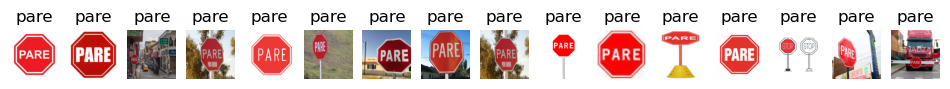

In [4]:
# dd = torch.utils.data.DataLoader(datasets.ImageFolder(root=ruta_validacion,transform = transforms.Compose([transforms.Resize((200,200)),transforms.ToTensor()])), batch_size=16, shuffle=False)
visualizar_imagenes_etiquetas(train_loader, conjunto_entrenamiento.classes)

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
      
        self.features = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2),
                                      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2))
        
        self.classifier = nn.Sequential(nn.Linear(70688, 5000),
                                        nn.Linear(5000,100),
                                        nn.Linear(100,2),
                                        nn.Sigmoid())
    def forward(self, x):

        z = self.features(x)
        z = z.view(z.size(0), -1)
        return self.classifier(z)
    
model = CNNModel().to('cuda')

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
max_epochs, best_valid_loss = 15, np.inf
running_loss = np.zeros(shape=(max_epochs, 2))
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
def update_step(data,label):
    prediction = model(data)
    optimizer.zero_grad()
    loss = criterion(prediction, label)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_step(data, label):
    prediction = model(data)
    loss = criterion(prediction, label)
    return loss.item()

def train_one_epoch():
    train_loss, valid_loss = 0.0, 0.0
    for batchx, batchy in train_loader:
        x, y = batchx, batchy
        x, y = x.to(device), y.to(device)
        train_loss += update_step(x, y)
    for batchx, batchy in valid_loader:
        x, y = batchx, batchy
        x, y = x.to(device), y.to(device)
        valid_loss += evaluate_step(x, y)

    factor = 10**5 # 100 elevado a los decimales que quiera para truncar los resultados 
    error_train = train_loss/len(train_loader.dataset)
    error_val = valid_loss/len(valid_loader.dataset)

    e_train_trunc = int(error_train*factor)/factor
    e_val_trunc = int(error_val*factor)/factor
    print("error train: ", e_train_trunc, "error val: ", e_val_trunc,"\n")
    return train_loss/len(train_loader.dataset), valid_loss/len(valid_loader.dataset)





Iteración 1/15
-------------------------------


d:\miniconda3\envs\torch\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


error train:  0.04116 error val:  0.04095 

Iteración 2/15
-------------------------------
error train:  0.03526 error val:  0.03568 

Iteración 3/15
-------------------------------
error train:  0.0305 error val:  0.03146 

Iteración 4/15
-------------------------------
error train:  0.02701 error val:  0.02855 

Iteración 5/15
-------------------------------
error train:  0.02493 error val:  0.02663 

Iteración 6/15
-------------------------------
error train:  0.02352 error val:  0.02538 

Iteración 7/15
-------------------------------
error train:  0.02271 error val:  0.02454 

Iteración 8/15
-------------------------------
error train:  0.02215 error val:  0.02394 

Iteración 9/15
-------------------------------
error train:  0.02173 error val:  0.02351 

Iteración 10/15
-------------------------------
error train:  0.02145 error val:  0.02319 

Iteración 11/15
-------------------------------
error train:  0.02125 error val:  0.02294 

Iteración 12/15
-----------------------------

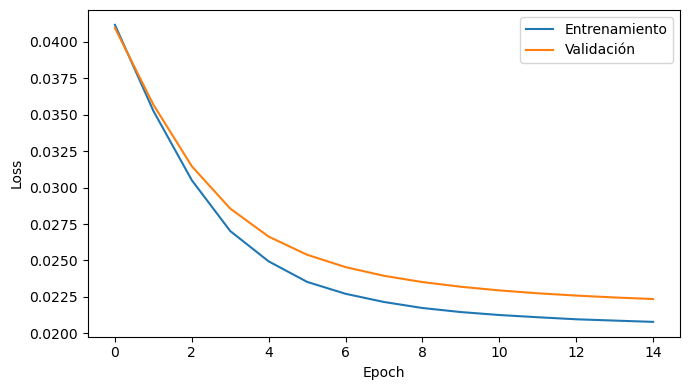

In [7]:
running_loss = np.zeros(shape=(max_epochs,2))
# running_val = np.zeros(shape=(max_epochs,2))
for epoch in range(max_epochs):
  print(f"Iteración {epoch+1}/{max_epochs}\n-------------------------------")
  # Entrenar
  running_loss[epoch]=train_one_epoch()
  # Validar
  # running_loss[epoch]=val_loop()

fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:,0], label='Entrenamiento')
ax.plot(running_loss[:,1], label='Validación')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()




Text(0.5, 1.0, '0')

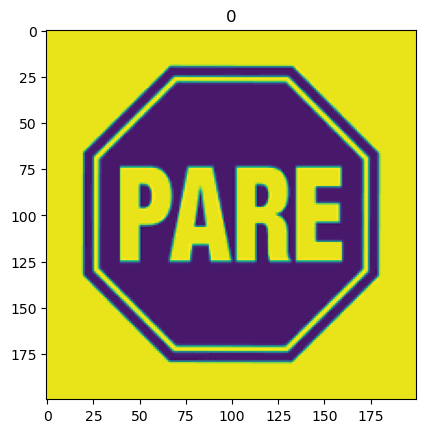

In [10]:
gg = 3
fig = plt.figure()
plt.imshow(conjunto_entrenamiento[gg][0][0].numpy())
plt.title(conjunto_entrenamiento[gg][1])   

In [ ]:
# from PIL import Image
# #img = Image.open(os.path.join(os.getcwd(),'dataset','val','pare', "20240511_164622.jpg"))
# img = Image.open(os.path.join(os.getcwd(),'cedaelpaso.jpeg'))
# img_tranform = transform(img)
# fig, ax = plt.subplots(figsize=(6, 4))
# ax.imshow(img_tranform.permute(dims=[1, 2, 0]).detach().numpy())


In [ ]:
# from skimage.exposure import (histogram,adjust_gamma,adjust_log,equalize_hist)
# import skimage.io as io
# from skimage.filters import (gaussian, sobel, median, inverse, roberts)
# from skimage.morphology import (disk, square, erosion,dilation,closing,opening,area_closing,area_opening)

# img = io.imread(os.path.join(os.getcwd(),'datospropios','train','pare','20240506_185217.jpg'), as_gray=True)

# edge_roberts = roberts(img)


# im_sb = sobel(edge_roberts)
# plt.figure(figsize=(10, 10))
# plt.imshow(edge_roberts)

In [ ]:
# img_tranform = img_tranform.to(device)
# probs = nn.Softmax(dim=1)(model.forward(img_tranform.unsqueeze(0)))
# best = probs.argsort(descending=True)
# display(best[0, :2],
#         probs[0, best[0, :5]])

In [8]:
x = conjunto_entrenamiento[5][0].to(device)
pp =[]
pp.append(x)
for capa in model.features:
    x = capa(x)
    pp.append(x)

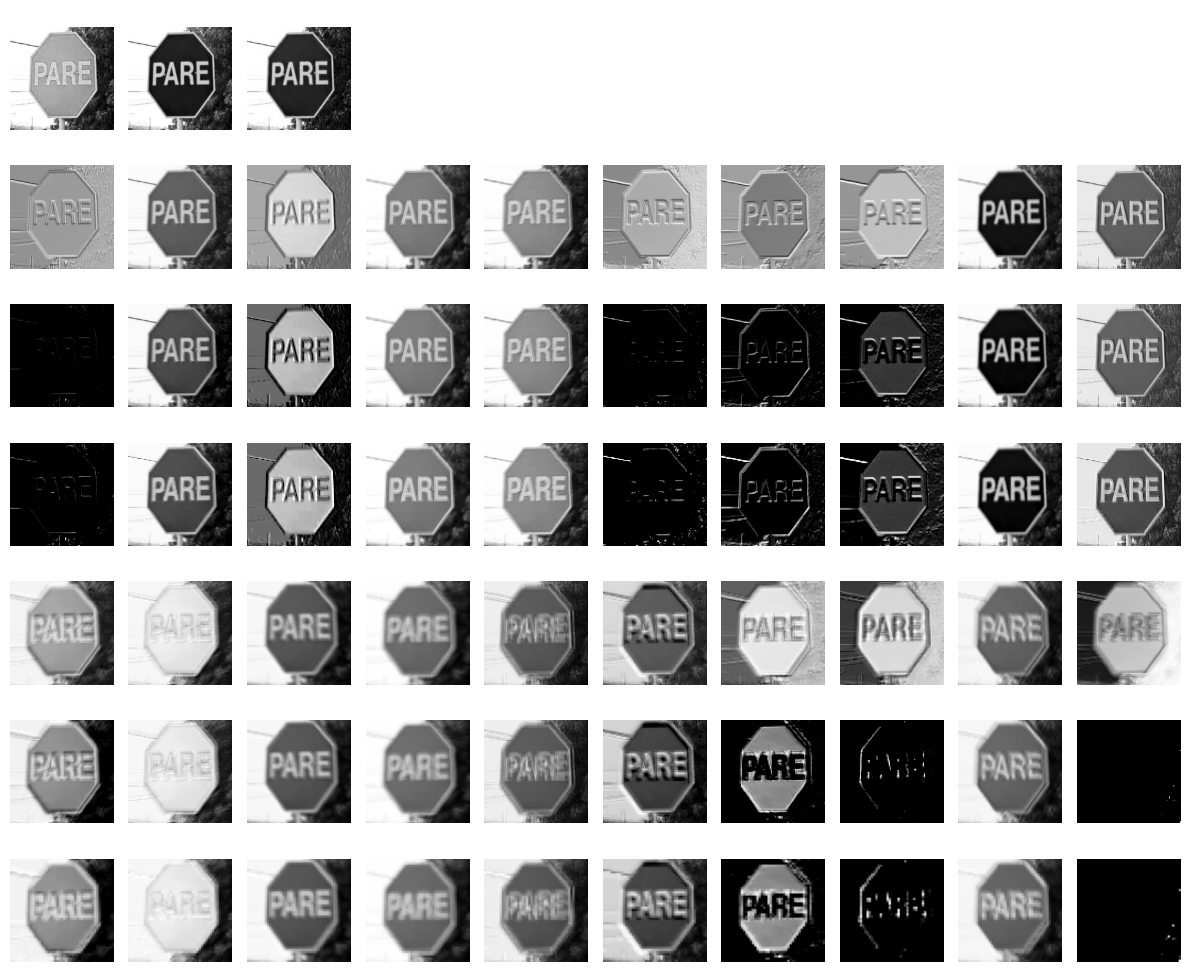

In [9]:
fig, ax = plt.subplots(len(pp), 10, figsize=(12, 10), tight_layout=True)

for k in range(len(pp)):
    image = pp[k].to('cpu').detach().numpy()
    if image.shape[0]==1:
        for l in range(10):
            if l==0:
                ax[k,l].imshow(image[0, :, :], cmap=plt.cm.Greys_r)
            else:
                ax[k,l].cla()
            ax[k,l].axis('off');
    else:
        for l in range(10):
            if image.shape[0]>l:
                ax[k,l].imshow(image[l, :, :], cmap=plt.cm.Greys_r)
            else:
                ax[k,l].cla()
            ax[k,l].axis('off');

In [10]:
x = x.flatten()
pp =[]
pp.append(x)
for capa in model.classifier:
    x = capa(x)
    pp.append(x)

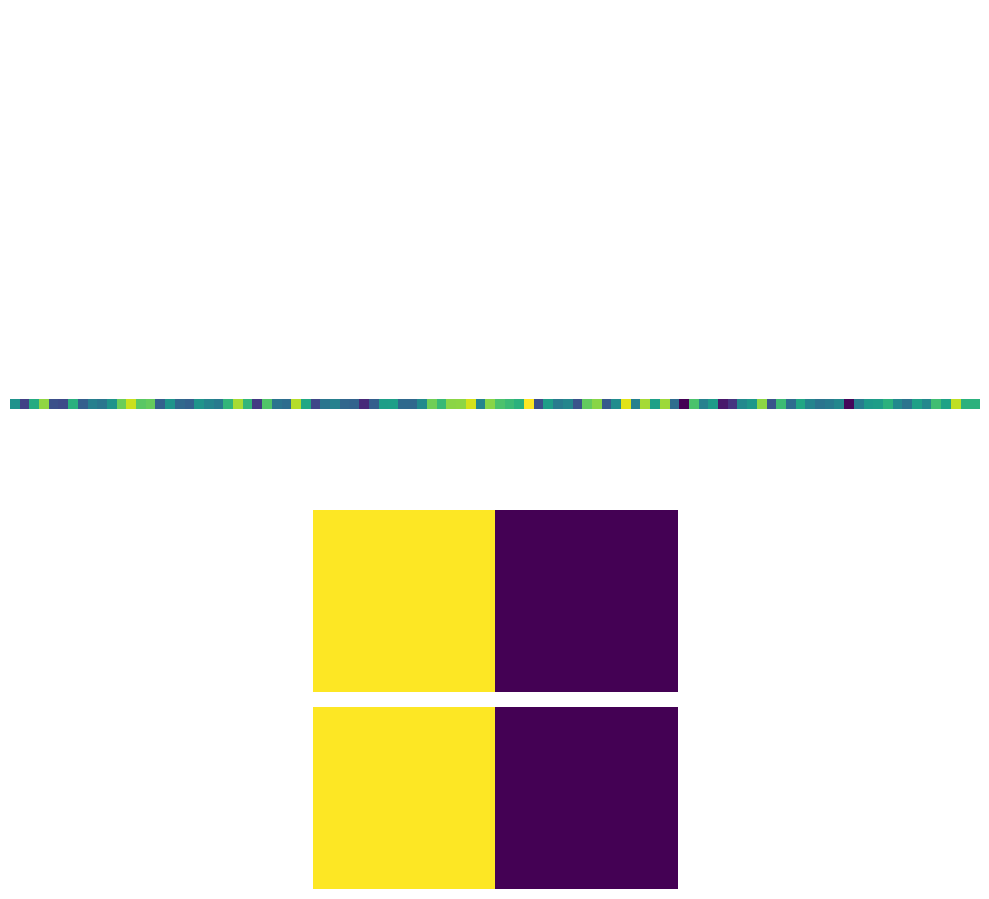

In [11]:
fig, ax = plt.subplots(len(pp), 1, figsize=(10, 10), tight_layout=True)

for k in range(len(pp)):
    image = pp[k].to('cpu').detach().numpy()
    ax[k].imshow(image[None, :])
    ax[k].axis('off');

MODEL PRE TRAINED

In [1]:
import torch
from torchvision import transforms, datasets, models
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import skimage.io as io
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [2]:
data_dir_Train = os.path.join(os.getcwd(),'model pre-trained')
data_dir_Test = os.path.join(os.getcwd(),'model pre-trained')
data_dir_pred = os.path.join(os.getcwd(),'model pre-trained')

train_dir = data_dir_Train + "/seg_train"
valid_dir = data_dir_Test + "/seg_test/"
pred_files = [os.path.join(data_dir_pred, f) for f in os.listdir(data_dir_pred)]

outcomes = os.listdir(train_dir)

In [3]:
print(outcomes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [3]:
transform = torchvision.transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(p=0.5), # randomly flip and rotate
    transforms.ColorJitter(0.3,0.4,0.4,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
    ])

# Augmentation on test images not needed
transform_tests = torchvision.transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
    ])

In [4]:
train_data = torchvision.datasets.ImageFolder(root=train_dir,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=valid_dir,transform=transform_tests)


valid_size = 0.15
# Splot data into train and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [5]:
train_loader = DataLoader(train_data,batch_size=50,sampler=train_sampler,num_workers=2)
valid_loader = DataLoader(train_data, batch_size =100, sampler=valid_sampler, num_workers=3)
test_loader= DataLoader(test_data,batch_size=32,shuffle=False,num_workers=2)

In [6]:
train_on_gpu = torch.cuda.is_available()

device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [ ]:
import torchvision
model = torchvision.models.wide_resnet50_2(pretrained=True)

for param in model.parameters():
    param.required_grad = False


num_ftrt = model.fc.in_features

model.fc = nn.Linear(num_ftrt,6)
model.to(device)


In [8]:
# number of epochs for training set
epochs = 5
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6], gamma=0.06)
# track change in validation loss
valid_loss_min = np.Inf
val_loss = []
tn_loss = []
for epoch in range(1,epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):       
        # move tensor to gpu if cuda is available
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # clear the gradiant of all optimizer variable
        optimizer.zero_grad()
        # forward pass: compute pradictions by passing inputs
        output = model(data)
        # calculate batch loss
        loss = criterion(output, target)
        # backward pass: compute gradiant of the loss with respect to the parameters
        loss.backward()
        # update parameters by optimizing single step
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)

    # validate the model

    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensor to gpu
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # forward pass: compute the validation predictions
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update the validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    val_loss.append(valid_loss)
    tn_loss.append(train_loss)
    # update learning rate
    # scheduler.step()
    # Print the train and validation loss statistic
    print('Epoch: {} \t Training Loss: {:.3f} \t Validation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss decrease
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased {:.4f}--->{:.4f}  Saving model...".format(valid_loss_min, valid_loss))
        # save current model
        torch.save(model.state_dict(), 'model_state.pt')
        valid_loss_min = valid_loss
    print('Learning Rate ------------->{:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

d:\miniconda3\envs\torch\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

----

In [1]:
import torch
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import transforms, datasets
import torch.optim as optim
from torch.utils.data import DataLoader
import os 
# # Definir transformaciones para preprocesamiento de imágenes
# transform = transforms.Compose([
#     transforms.Resize([256,256]),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# ruta_entrenamiento = os.path.join(os.getcwd(),'dataset','train')#"C:/Users/basti/OneDrive/Escritorio/bigdataseñaleticas/dataset/train"
# ruta_validacion    = os.path.join(os.getcwd(),'dataset','val')#"C:/Users/basti/OneDrive/Escritorio/bigdataseñaleticas/dataset/val"

# # Cargar el conjunto de datos
# conjunto_entrenamiento = datasets.ImageFolder(root=ruta_entrenamiento, transform=transform)
# train_loader = DataLoader(conjunto_entrenamiento, batch_size=32, shuffle=True)

# Cargar el modelo pre-entrenado
resnet = models.resnet18(weights=True)


# Congelar parámetros de todas las capas excepto la última
for param in resnet.parameters():
    param.requires_grad = False

# Modificar la última capa para adaptarla a tu tarea de clasificación binaria
num_ftrs = resnet.fc.in_features

resnet.fc = nn.Linear(num_ftrs, 6)  # 2 clases: pare y no pare

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# Entrenamiento del modelo
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Guardar el modelo entrenado
torch.save(resnet.state_dict(), "resnet_model1.pth")


d:\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


OSError: Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "d:\miniconda3\envs\torch\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "d:\miniconda3\envs\torch\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "d:\miniconda3\envs\torch\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "d:\miniconda3\envs\torch\lib\site-packages\torchvision\datasets\folder.py", line 245, in __getitem__
    sample = self.loader(path)
  File "d:\miniconda3\envs\torch\lib\site-packages\torchvision\datasets\folder.py", line 284, in default_loader
    return pil_loader(path)
  File "d:\miniconda3\envs\torch\lib\site-packages\torchvision\datasets\folder.py", line 262, in pil_loader
    with open(path, "rb") as f:
OSError: [Errno 22] Invalid argument: 'e:\\bigdataseñaleticas\\model pre-trained/seg_train\\buildings\\81\x100!0.jpg'


In [6]:
import torch
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import torch.nn as nn
# Cargar la imagen y aplicar transformaciones
imagen_path = "pare.jpg"
transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
imagen = Image.open(imagen_path)
imagen_tensor = transform(imagen).unsqueeze(0)  # Añadir dimensión del batch

# Cargar el modelo entrenado
modelo = models.resnet18(weights=False)  # Aquí asumo que ya has definido y entrenado tu modelo
modelo.fc = nn.Linear(modelo.fc.in_features, 2)  # Asegúrate de que la última capa coincide con tu modelo entrenado
modelo.load_state_dict(torch.load("resnet_model1.pth"))
modelo.eval()

# Hacer la predicción
with torch.no_grad():
    outputs = modelo(imagen_tensor)
    _, predicted = torch.max(outputs, 1)

# Decodificar la predicción
clases = ['no pare', 'pare']
prediccion = clases[predicted.item()]

print("Predicción:", prediccion)
outputs

d:\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicción: no pare


tensor([[ 5.5112, -5.8222]])

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from torchvision import datasets, models, transforms

# Definir transformaciones para preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar conjunto de datos de entrenamiento
train_data = datasets.ImageFolder(os.path.join(os.getcwd(),'dataset','train'), transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Cargar modelo pre entrenado de AlexNet
model = models.alexnet(pretrained=True)

# Reemplazar la capa de salida
num_classes = 2  # Pare y No Pare
model.classifier[6] = nn.Linear(4096, num_classes)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

# Entrenamiento del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 15

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Guardar el modelo entrenado
torch.save(model.state_dict(), 'modelo_entrenado.pth')

c:\Users\basti\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\basti\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\basti\miniconda3\envs\torch\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\basti\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_P

Epoch [1/15], Loss: 0.3076
Epoch [2/15], Loss: 0.1547
Epoch [3/15], Loss: 0.1046
Epoch [4/15], Loss: 0.0731
Epoch [5/15], Loss: 0.0568
Epoch [6/15], Loss: 0.0519
Epoch [7/15], Loss: 0.0442
Epoch [8/15], Loss: 0.0369
Epoch [9/15], Loss: 0.0350
Epoch [10/15], Loss: 0.0307
Epoch [11/15], Loss: 0.0269
Epoch [12/15], Loss: 0.0259
Epoch [13/15], Loss: 0.0256
Epoch [14/15], Loss: 0.0204
Epoch [15/15], Loss: 0.0200


In [3]:
from PIL import Image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar el modelo pre entrenado
model = models.alexnet(pretrained=False)
num_classes = 2  # Pare y No Pare
model.classifier[6] = nn.Linear(4096, 2)
model.load_state_dict(torch.load('modelo_entrenado.pth'))
model.eval()

image = Image.open(os.path.join(os.getcwd(),'cedaelpaso.jpeg'))
image = transform(image)
image = image.unsqueeze(0)  # Agregar dimensión extra para el tamaño del lote

# Realizar la predicción
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# Obtener la etiqueta predicha
labels = ['Pare', 'No Pare']
predicted_label = labels[predicted.item()]

print(f'Etiqueta predicha: {predicted_label}')
outputs

Etiqueta predicha: Pare


tensor([[ 1.0471, -0.4696]])